In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import urlparse
import urllib
import re

In [2]:
%matplotlib inline

In [3]:
%time orig = pd.read_csv('sample_20150117.log', sep='\t', header=None, names=['ip', 'date', 'method', 'page', 'status', 'refer'])

CPU times: user 137 ms, sys: 11.5 ms, total: 149 ms
Wall time: 229 ms


In [4]:
member_log = orig.ix[:5000, :]
#member_log = orig

In [5]:
member_log['date'] = member_log['date'].apply(lambda row: time.mktime(datetime.strptime(row, '%d/%b/%Y:%H:%M:%S').timetuple()))

/home/dboyliao/.pyenv/versions/anaconda-2.0.1/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [6]:
g = member_log.groupby('ip')

In [7]:
member_log['session'] = g['date'].apply(lambda s: (s - s.shift(1) > 3).fillna(0).cumsum(skipna=False))

/home/dboyliao/.pyenv/versions/anaconda-2.0.1/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
session_length = member_log.groupby(['ip', 'session']).size()

In [9]:
reduced = member_log.merge(session_length[session_length > 3].reset_index()[['ip', 'session']], how='inner', on=['ip', 'session'])

In [10]:
q = reduced['page'].apply(lambda p: urlparse.urlparse(p).query).apply(lambda p: urlparse.parse_qsl(p))

In [11]:
q

0     [(refer, http://mybid.ruten.com.tw/master/my.p...
1                                                    []
2                                                    []
3             [(key, 683a435bd06340da84c9703072f34c05)]
4     [(refer, http://mybid.ruten.com.tw/master/my.p...
5                                                    []
6             [(key, e5f72f4acf35e0ecfcafca7a61395224)]
7     [(refer, https://member.ruten.com.tw/user/logi...
8                                                    []
9                                                    []
10            [(key, 10ef451b0cb71da18a3bf3ae9bd9801c)]
11    [(refer, https://member.ruten.com.tw/user/logi...
12                                                   []
13                                                   []
14            [(key, 96ad2f5e2efbad6d5e69842c5fa68def)]
...
2678                                                   []
2679                                                   []
2680                                    

In [12]:
q[q.apply(len) > 2] 

124    [(refer, http://www.ruten.com.tw/), (btn_login...
125    [(refer, http://www.ruten.com.tw/), (btn_login...
127    [(refer, http://www.ruten.com.tw/), (btn_login...
135    [(refer, http://www.ruten.com.tw/), (btn_login...
136    [(refer, http://www.ruten.com.tw/), (btn_login...
148    [(refer, http://www.ruten.com.tw/), (btn_login...
149    [(refer, http://www.ruten.com.tw/), (btn_login...
174    [(refer, http://www.ruten.com.tw/), (btn_login...
178    [(refer, http://www.ruten.com.tw/), (btn_login...
181    [(refer, http://www.ruten.com.tw/), (btn_login...
261    [(refer, http://www.ruten.com.tw/), (btn_login...
265    [(refer, http://www.ruten.com.tw/), (btn_login...
315    [(refer, http://www.ruten.com.tw/), (btn_login...
326    [(refer, http://www.ruten.com.tw/), (btn_login...
330    [(refer, http://www.ruten.com.tw/), (btn_login...
...
2168    [(refer, http://www.ruten.com.tw/), (btn_login...
2169    [(refer, http://www.ruten.com.tw/), (btn_login...
2170    [(refer, http://w

In [13]:
q.apply(lambda x: len(x) > 1).sum()

174

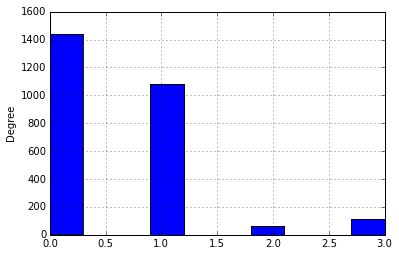

In [14]:
q.apply(len).plot(kind='hist')

In [15]:
q2 = q[q.apply(lambda x: len(x)) > 1]

In [16]:
zip(*q2[124])

[('refer', 'btn_login_x', 'btn_login_y'),
 ('http://www.ruten.com.tw/', '154', '77')]

In [17]:
q2.apply(lambda x: zip(*x))

124    [(refer, btn_login_x, btn_login_y), (http://ww...
125    [(refer, btn_login_x, btn_login_y), (http://ww...
127    [(refer, btn_login_x, btn_login_y), (http://ww...
135    [(refer, btn_login_x, btn_login_y), (http://ww...
136    [(refer, btn_login_x, btn_login_y), (http://ww...
148    [(refer, btn_login_x, btn_login_y), (http://ww...
149    [(refer, btn_login_x, btn_login_y), (http://ww...
169    [(err_code, refer), (1, http://www.ruten.com.tw)]
174    [(refer, btn_login_x, btn_login_y), (http://ww...
178    [(refer, btn_login_x, btn_login_y), (http://ww...
181    [(refer, btn_login_x, btn_login_y), (http://ww...
261    [(refer, btn_login_x, btn_login_y), (http://ww...
265    [(refer, btn_login_x, btn_login_y), (http://ww...
307    [(err_code, refer), (1, http://www.ruten.com.t...
315    [(refer, btn_login_x, btn_login_y), (http://ww...
...
2321    [(refer, btn_login_x, btn_login_y), (http://ww...
2322    [(refer, btn_login_x, btn_login_y), (http://ww...
2338       [(err_code, re

In [18]:
q3 = np.concatenate(q2.values)

In [21]:
q3.tolist()

[['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '154'],
 ['btn_login_y', '77'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '143'],
 ['btn_login_y', '45'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '103'],
 ['btn_login_y', '33'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '79'],
 ['btn_login_y', '41'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '130'],
 ['btn_login_y', '90'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '96'],
 ['btn_login_y', '44'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '75'],
 ['btn_login_y', '64'],
 ['err_code', '1'],
 ['refer', 'http://www.ruten.com.tw'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '71'],
 ['btn_login_y', '104'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '114'],
 ['btn_login_y', '86'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x', '74'],
 ['btn_login_y', '69'],
 ['refer', 'http://www.ruten.com.tw/'],
 ['btn_login_x'

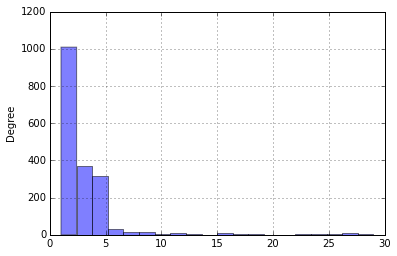

In [22]:
pd.Series(session_length).reset_index(drop=True).plot(kind='hist', bins=20, alpha=0.5)

In [23]:
sessions.apply(lambda x: map(lambda s: (s-s.shift(1)).fillna(0).mean(),x)).apply(np.mean).reset_index(drop=True).plot(kind='hist', bins=20, alpha=0.5)

NameError: name 'sessions' is not defined

In [24]:
member_log['src'] = member_log.page.apply(urlparse.urlparse).apply(lambda p: p[2])

/home/dboyliao/.pyenv/versions/anaconda-2.0.1/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
g2 = member_log.groupby(['ip', 'src'])

In [26]:
session_tbl = g2['src'].apply(lambda p: len(p))

### 每個user對相同檔案的請求次數 (包含 gif, png ...)

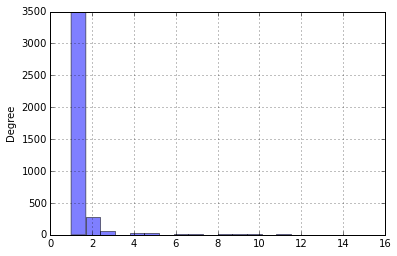

In [27]:
session_tbl.plot(kind='hist', bins=20, alpha=0.5)

In [28]:
session_num_page = session_tbl.groupby(level=1).sum()

In [29]:
session_num_page.sort(ascending=False)

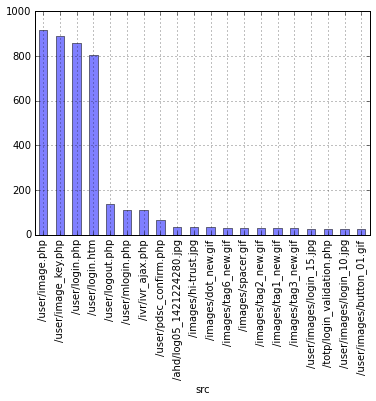

In [30]:
session_num_page[:20].plot(kind='bar', alpha=0.5)

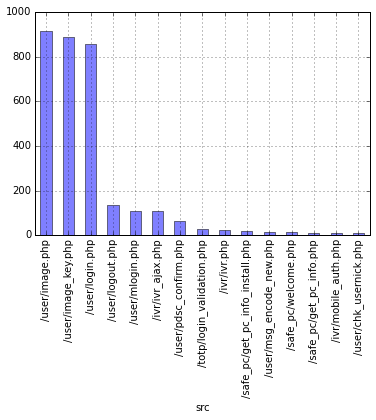

In [31]:
session_num_page[map(lambda row: re.search(r'\.php$', row) != None, session_num_page.index)][:15].plot(kind='bar', alpha=0.5)

In [32]:
session_num_page[map(lambda row: re.search(r'\.php$', row) != None, session_num_page.index)][:15].to_frame()

,src
src,
/user/image.php,915
/user/image_key.php,888
/user/login.php,857
/user/logout.php,135
/user/mlogin.php,110
/ivr/ivr_ajax.php,108
/user/pdsc_confirm.php,66
/totp/login_validation.php,26
/ivr/ivr.php,24


In [33]:
g3 = member_log.groupby('ip')

### 每個user訪問非php檔案

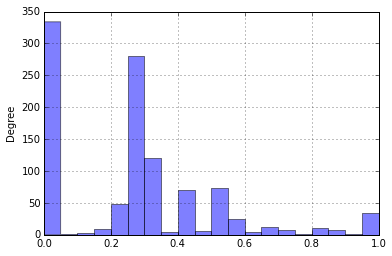

In [34]:
g3['src'].apply(lambda row: row.apply(lambda p: re.search(r'\.php$', p) == None).sum()*(1.0) / len(row)).reset_index(drop=True).plot(kind='hist', bins=20, alpha=0.5)

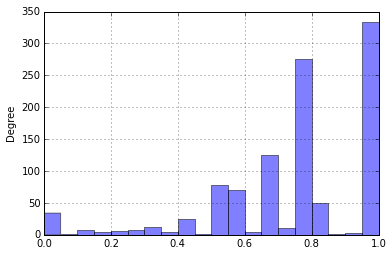

In [35]:
g3['src'].apply(lambda row: row.apply(lambda p: re.search(r'\.php$', p) != None).sum()*(1.0) / len(row)).reset_index(drop=True).plot(kind='hist', bins=20, alpha=0.5)

### 每個user, 非200訪問的比例

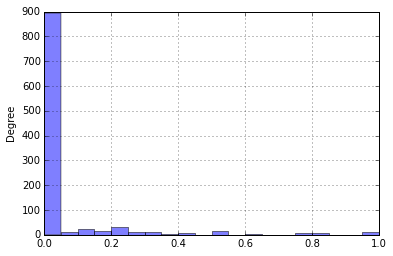

In [36]:
g3['status'].apply(lambda row: (row != 200).sum()*(1.0) / len(row)).reset_index(drop=True).plot(kind='hist', bins=20, alpha=0.5)

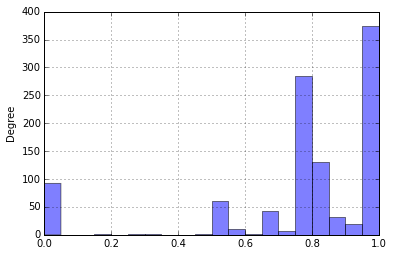

In [37]:
g3['method'].apply(lambda m: (m=='GET').sum()*(1.0) / len(m)).reset_index(drop=True).plot(kind='hist', bins=20, alpha=0.5)

In [38]:
member = dict(list(g['page']))

In [39]:
len(member.values())

1058

In [40]:
zip([2,3,4],[1,2,3], (5,6,7))

[(2, 1, 5), (3, 2, 6), (4, 3, 7)]

In [41]:
tmp = map(lambda p: urlparse.urlparse(p).query, member.values())

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:
%time query = map(lambda m: m.apply(lambda p: {urlparse.urlparse(p).path: urlparse.urlparse(p).query}), member.values())


In [ ]:
%time qs = map(lambda q: q.apply(lambda r: (r.keys()[0], dict(urlparse.parse_qsl(r.values()[0])))), query)

In [ ]:
def f_parse(q):
    
    path, para, val = [], [], []
    
    map(lambda x: path.extend(x), [[k]*len(v)  for k, v in q if len(v) > 0])
    map(lambda y: para.extend(y), [v.keys() for k, v in q if len(v) > 0])    
    map(lambda z: val.extend(z), [v.values() for k, v in q if len(v) > 0])
    
    #x = pd.DataFrame({'val_path':path, 'val_para':para, 'val':val}).groupby(['val', 'val_para']).count().apply(lambda x: x>1).count(axis=0)
    #y = pd.DataFrame({'val_path':path, 'val_para':para, 'val':val}).groupby(['val', 'val_path']).count().apply(lambda x: x>1).count(axis=0)
    #return x.append(y)
    return (path, para, val)
    

In [ ]:
%time tbl = map(f_parse, qs)

In [42]:
def cal_score(p):
    path, para, val = p[0], p[1], p[2]
    x = pd.DataFrame({'val_path':path, 'val_para':para, 'val':val}).groupby(['val', 'val_para']).count().apply(lambda x: x>1).count(axis=0)
    y = pd.DataFrame({'val_path':path, 'val_para':para, 'val':val}).groupby(['val', 'val_path']).count().apply(lambda x: x>1).count(axis=0)
    return x.append(y)
    

In [43]:
%time score = pd.concat(map(cal_score, tbl[:5000]), join='outer', axis = 1).T

NameError: name 'tbl' is not defined

## 預計要跑1小時 Orz

In [44]:
%time score = pd.concat(map(cal_score, tbl), join='outer', axis = 1).T

NameError: name 'tbl' is not defined

In [45]:
score.val_para.value_counts().sum()

NameError: name 'score' is not defined

In [ ]:
score.val_para.plot(kind='hist',bins=30, alpha=0.5)

In [ ]:
score.val_path.plot(kind='hist',bins=30, alpha=0.5)

In [ ]:
score.val_para[score.val_para > 10].plot(kind='hist',bins=20, alpha=0.5)

In [ ]:
score.val_path[score.val_path > 10].plot(kind='hist',bins=20, alpha=0.5)